In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210505_07_54_14_000_T4CaxysrQ7W21Wgl1wZWBCtdRjE3_F_3264_2448.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210518_06_25_57_000_6SLj9T2MBmhTqitpNcjcjOVAYyG2_F_3000_4000.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210512_09_41_56_000_ovRKxW0QbBVfwN9RW4teROP1YgG3_F_4160_3120.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210512_13_32_08_000_vVGqfiibxjRMSkSyttjdIlsHrj92_F_3000_4000.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210517_13_00_53_000_QTHwLcCLJSgc8mdgtvUWq1eiMT52_F_3264_2448.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210522_00_57_36_000_z2umdg3LdTXQFkhWMsDipg7Sys22_T_4160_3120.jpg
/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/Tempo Traveller/20210521_09_35_46_000_3i9IwxEEa6UEWq4gEOQ2NQnD0uz2_F

In [14]:
import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.optim.sgd import SGD
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR, LinearLR, StepLR

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from dataclasses import dataclass

import numpy as np
import pandas as pd
import random
import tqdm
import os

import matplotlib.pyplot as plt
import matplotlib
import typing as tp

In [15]:
seed: int = 0
device: str = 'cpu'
torch.cuda.is_available()

False

In [16]:
@dataclass
class Config:
    # Данные
    batch_size: int = 64
    do_shuffle_train: bool = True
    img_size: int = 224
    ratio_train_val_test: tuple[float, float, float] = (0.8, 0.1, 0.1)

    # Модель
    hidden_dim: int = 512
    p_dropout: float = 0.3
    n_alpha: float = 0.3

    # Обучение
    n_epochs: int = 100
    lr: float = 1e-5
    scheduler_type: tp.Literal["exp", "linear", "step"] | None = None
    optimizer_type: tp.Literal["sgd", "adam"] = "sgd"


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)

def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

config = Config()
enable_determinism()
fix_seeds(seed)

['Tractor']


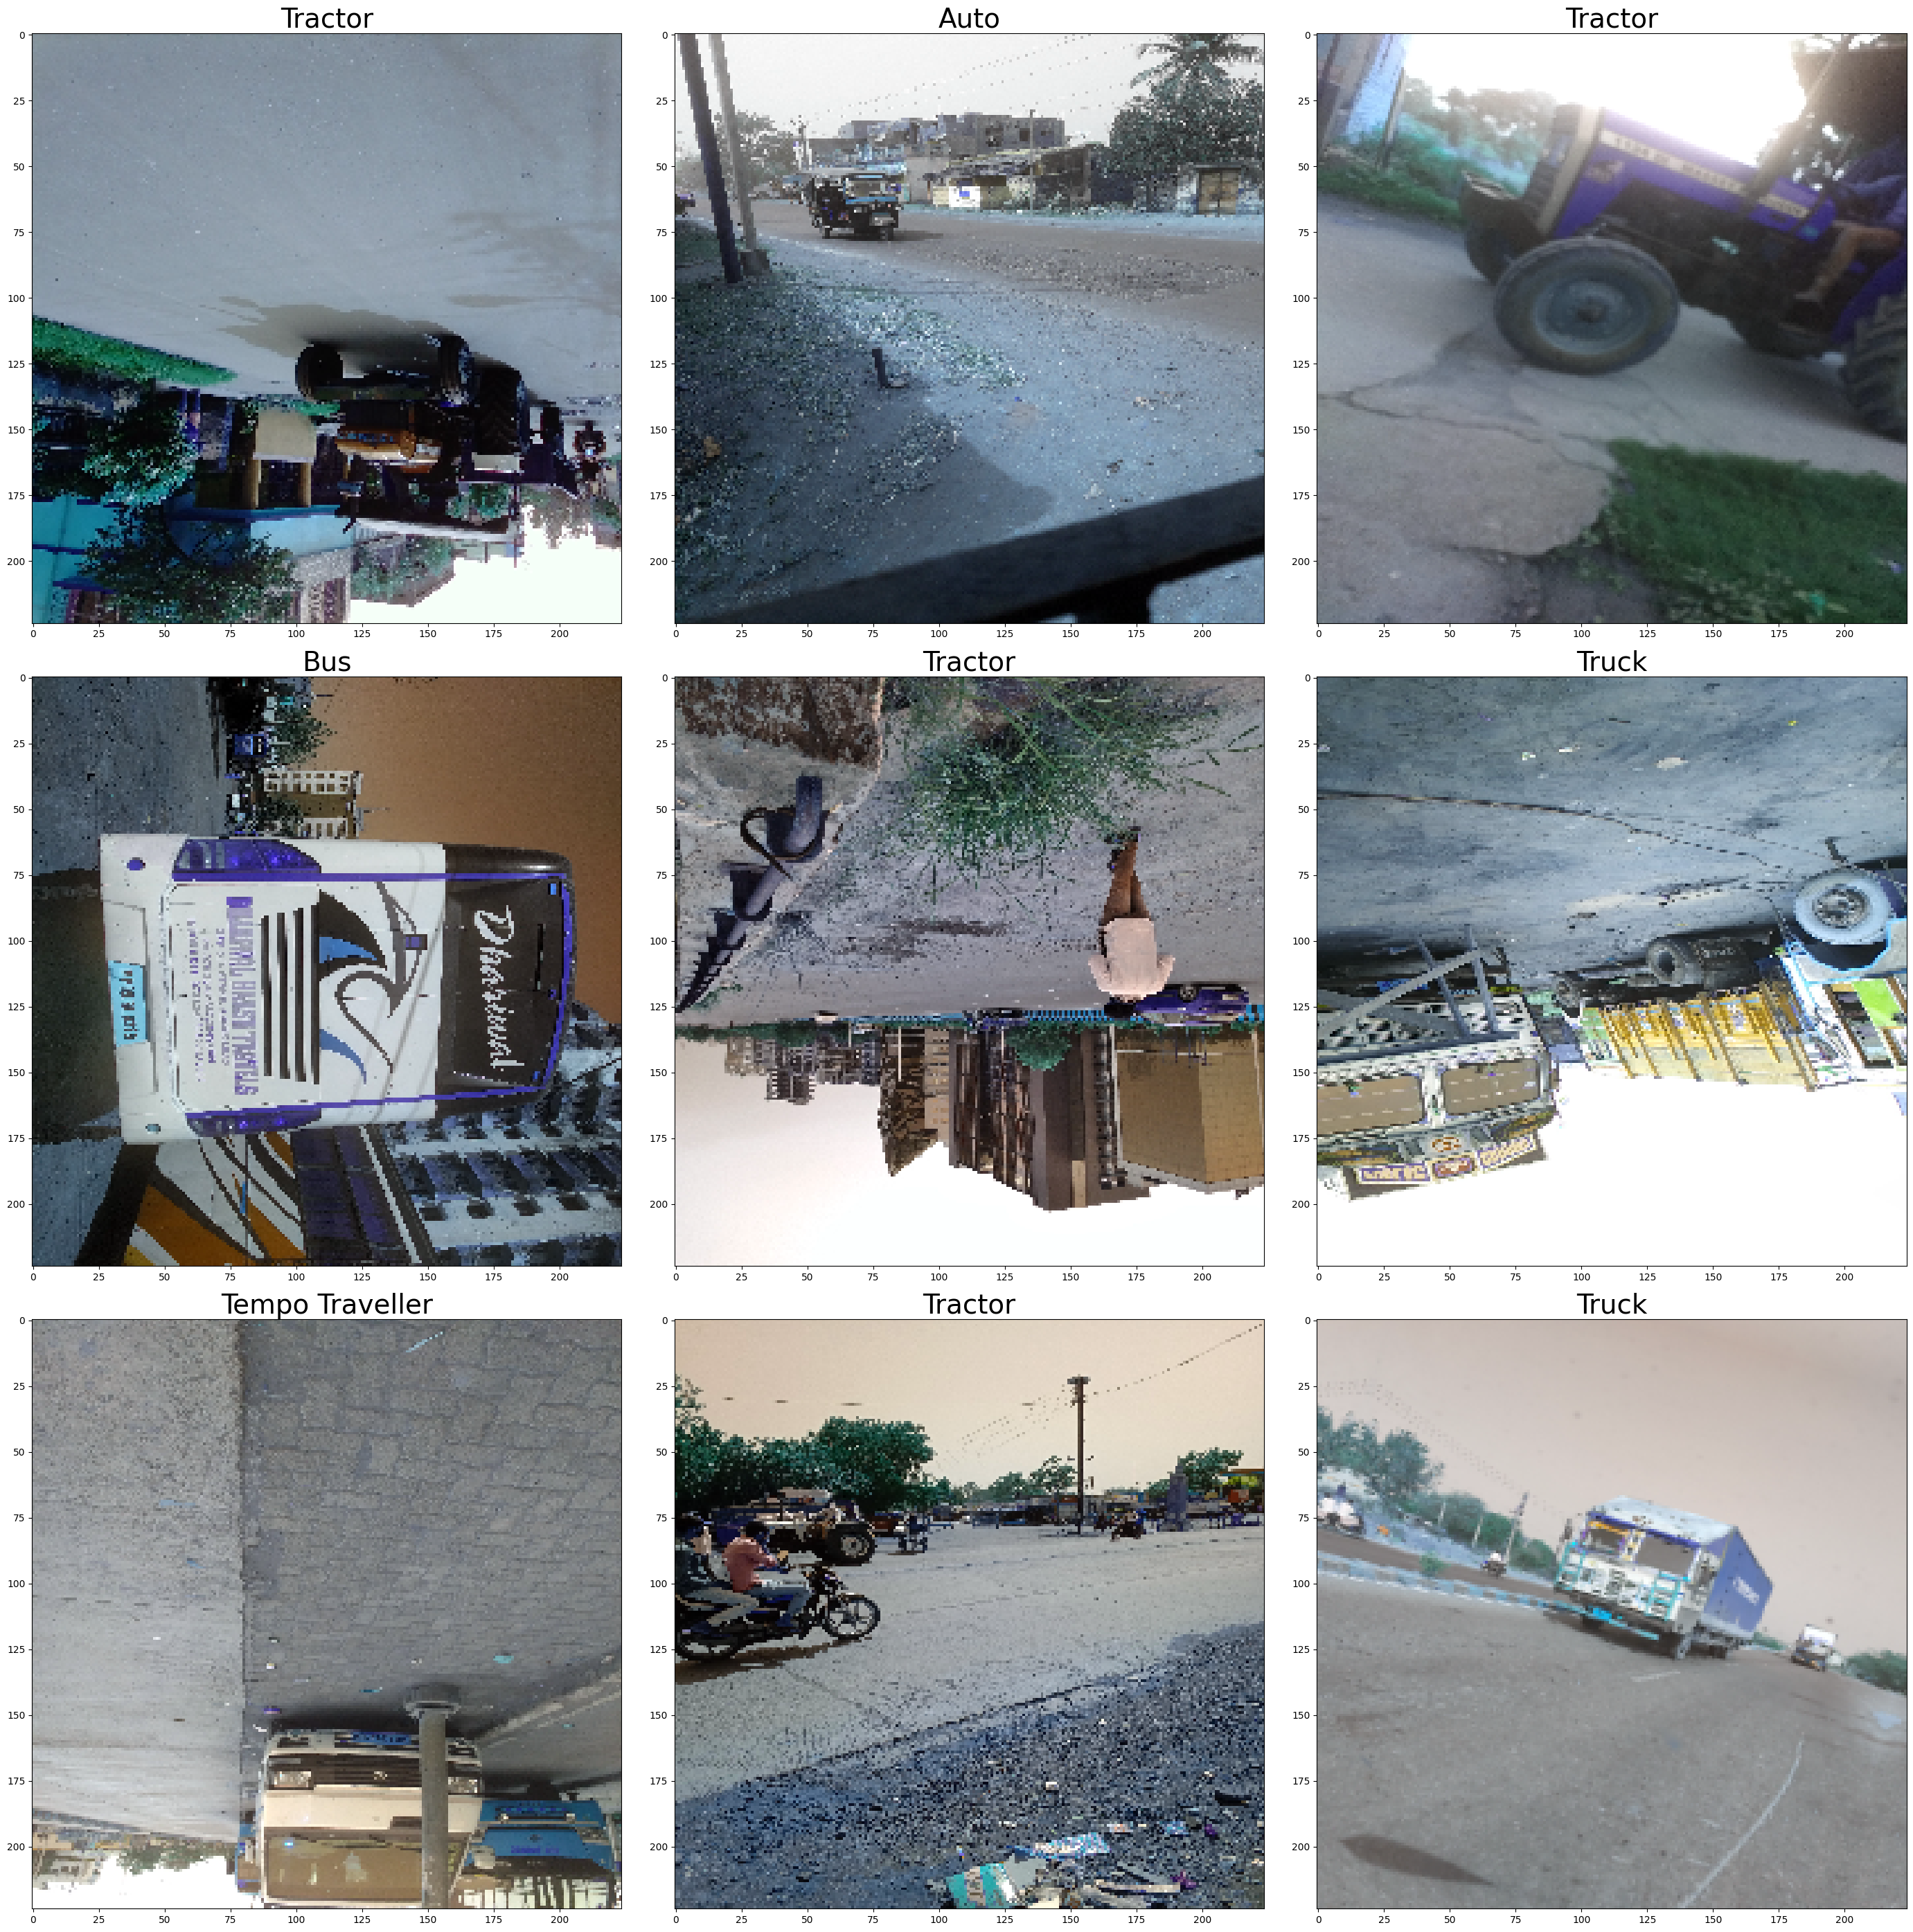

In [17]:
class GetDataset(Dataset):
    def __init__(self, path_folder, image_size):
        self.path_folder = path_folder
        self.paths = []
        self.labels = []
        self.image_size = image_size
        self.encoder = self.settings()
        self.transforms = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Rotate(limit=45, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomCrop(width=self.image_size, height=self.image_size, p=0.5),
            A.ToFloat(max_value=255),
            ToTensorV2(),
        ])

    def __getitem__(self, index) -> tuple[torch.Tensor, list]:
        img_numpy = cv2.imread(self.paths[index])
        label = self.labels[index]
        img_tensor = self.transforms(image=img_numpy)
        return img_tensor['image'], torch.tensor(self.encoder.transform([label])[0])

    def show_images(self, nrows: int = 3, ncols: int = 3):
        choice: np.ndarray = np.random.randint(low=0, high=self.__len__(), size=(nrows*ncols,))
        fig: matplotlib.figure.Figure
        ax: np.ndarray
        fig, ax = plt.subplots(nrows, ncols, figsize=[28, 28])
        ind_img: int = 0
        for row in range(nrows):
            for col in range(ncols):
                image, label = self.__getitem__(choice[ind_img])
                ax[row, col].imshow(image.permute((1, 2, 0)))
                ax[row, col].set_title(self.encoder.inverse_transform([label.item()])[0], fontsize=28)
                ind_img += 1
        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self.paths)
        
    def list_dataset(self):
        for label in os.listdir(self.path_folder):
            for img in os.listdir(self.path_folder + label):
                self.paths.append(self.path_folder + label + "/" + img)
                self.labels.append(label)
        
    def settings(self):
        self.list_dataset()
        return LabelEncoder().fit(self.labels[:])

    def decode(self, data:list):
        data = [data.item()]
        return self.encoder.inverse_transform(data)

fix_seeds(seed)
dataset = GetDataset("/kaggle/input/indian-vehicle-dataset/Vehicle_5_classes_sample/", 224)
print(dataset.decode(dataset[700][1]))
dataset.show_images()

In [18]:
generator = torch.Generator()
generator.manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=config.ratio_train_val_test, generator=generator)

In [19]:
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=config.do_shuffle_train,
    generator=generator,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    worker_init_fn=seed_worker,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
)

In [29]:
import torch
from torchvision import models

model = models.resnet18()
model.load_state_dict(torch.load("/kaggle/input/vehicle/resnet18-f37072fd.pth"))
model = models.resnet18(pretrained=True)

/tmp/ipykernel_30/1226424641.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/vehicle/resnet18-f37072fd.pth"))
Downloading

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [30]:
for param in model.parameters():
    param.requires_grad = False

In [32]:
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 5)

In [33]:
trainable_params = []
for param in model.parameters():
    if param.requires_grad:
        trainable_params.append(param)


In [36]:
def accuracy(*, y_pred, y_true):
    f1 = f1_score(y_pred, y_true, average='weighted')
    acc = accuracy_score(y_pred, y_true)
    return f1, acc

In [38]:
def train_loop(config: Config,
               model: nn.Module,
               train_loader: DataLoader,
               val_loader: DataLoader,
               accuracy: tp.Callable[[torch.Tensor, torch.Tensor], tp.Tuple[float, float]],
               device: str,
               params_subset: list | None = None,
              ):
    if params_subset is None:
        params_subset = model.parameters()
    model.to(device)
    optim = Adam(params_subset, lr=config.lr)
    model.train()
    for epoch in range(config.n_epochs):
        print(f"Epoch #{epoch + 1}/#{config.n_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            optim.zero_grad()
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)
            loss: torch.Tensor = F.cross_entropy(model(img_batch), true_labels)
            loss.backward()
            optim.step()
        with torch.no_grad():
            model.eval()
            f1_list, acc_list = [], []
            for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(val_loader)):
                pred_labels = np.stack([np.argmax(i) for i in model(img_batch).squeeze().detach().numpy()])
                print(pred_labels)
                f1, acc = accuracy(y_pred=pred_labels, y_true=true_labels)
                f1_list.append(f1)
                acc_list.append(acc)
            print(np.mean(f1_list), np.mean(acc_list))
            model.train()

In [39]:
train_loop(config, model, train_loader, val_loader, accuracy, device, params_subset=trainable_params)

Epoch #1/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.69s/it]


[4 4 1 4 2 2 2 2 2 1 1 2 2 4 4 4 1 4 2 4 1 1 1 4 2 2 2 2 2 1 4 2 2 2 2 2 2
 4 4 4 3 2 1 4 2 4 2 2 4 2 4 1 1 4 2 2 4 2 4 2 2 1 1 1]
0.2786525974025974 0.28125
Epoch #2/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


[4 1 4 4 3 4 2 4 1 1 1 4 2 1 2 1 1 2 2 4 0 1 4 4 1 2 1 2 1 2 4 2 2 4 1 2 1
 4 2 2 2 1 2 2 2 3 2 2 4 4 4 2 1 1 1 2 4 2 4 2 2 1 2 4]
0.3313215372355839 0.328125
Epoch #3/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.23s/it]


[1 1 1 4 2 4 1 4 2 1 4 4 1 0 2 4 2 2 2 4 4 2 1 4 4 4 2 2 4 1 1 2 2 2 4 2 1
 2 2 2 3 1 4 1 2 2 4 2 4 2 4 2 4 1 1 2 4 2 3 2 2 1 2 4]
0.35841013824884793 0.359375
Epoch #4/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.00s/it]


[4 1 2 4 3 2 2 4 1 2 4 2 2 1 4 4 1 2 2 4 1 1 3 4 3 2 2 2 1 1 4 2 2 4 1 2 1
 4 4 4 1 1 3 1 1 1 2 2 1 1 4 2 1 3 1 4 4 2 3 2 2 4 2 4]
0.2629761904761905 0.25
Epoch #5/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.03s/it]


[1 1 1 1 4 2 2 2 1 2 1 4 1 2 1 1 3 2 2 4 1 2 1 4 1 2 2 2 4 3 4 2 2 4 2 2 1
 4 2 4 3 4 3 1 2 1 4 2 4 4 4 2 2 3 1 4 4 2 3 0 2 4 3 3]
0.3624198717948718 0.359375
Epoch #6/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:24<03:12, 24.01s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.06s/it]


[4 1 2 4 3 4 2 4 2 1 1 4 2 4 4 1 2 2 2 4 4 3 4 4 1 1 3 2 1 1 1 2 2 4 2 2 1
 4 0 4 0 4 3 2 2 3 4 2 4 4 4 4 2 1 4 4 4 4 3 3 2 4 3 4]
0.5423652447089946 0.546875
Epoch #7/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.93s/it]


[4 1 3 4 3 4 2 4 1 2 1 4 1 0 4 1 3 2 2 4 4 2 4 4 1 1 3 2 4 3 4 2 1 4 4 2 4
 4 0 4 3 1 3 1 3 1 4 2 4 2 4 0 2 1 4 4 3 3 3 3 3 2 4 3]
0.5001354548229549 0.484375
Epoch #8/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.06s/it]


[4 1 2 4 3 4 1 4 3 1 1 1 2 4 4 4 3 2 2 4 1 2 4 4 2 4 3 2 4 3 4 2 2 3 2 0 4
 2 2 4 0 4 3 1 2 3 4 2 4 4 4 2 2 1 4 4 4 4 3 3 2 1 3 4]
0.45867582925862305 0.453125
Epoch #9/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:24<03:13, 24.23s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.05s/it]


[1 1 2 4 3 4 0 4 1 1 1 4 1 0 4 1 3 2 3 4 1 3 4 4 2 4 3 2 3 3 4 2 1 4 1 2 4
 2 1 4 0 4 2 3 3 4 4 2 4 2 4 2 1 1 4 4 4 3 3 3 2 4 4 4]
0.46660293651251294 0.453125
Epoch #10/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.07s/it]


[4 1 2 4 3 4 0 4 4 1 1 4 1 4 4 1 3 2 2 4 4 3 4 4 2 4 3 4 1 3 4 2 3 3 2 2 4
 2 4 4 0 4 2 1 1 4 3 2 4 4 4 0 2 1 4 0 4 3 3 3 4 4 4 3]
0.5380952380952381 0.515625
Epoch #11/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.90s/it]


[2 1 2 4 3 4 0 4 3 1 4 4 1 0 0 1 2 2 2 4 4 2 4 4 4 1 3 2 1 4 4 2 3 3 3 2 4
 2 0 4 0 4 0 1 4 2 3 2 4 4 4 0 2 4 1 4 3 3 3 3 3 1 3 3]
0.5193937440808166 0.515625
Epoch #12/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.54s/it]


[4 1 2 4 3 4 0 4 1 2 1 4 1 4 4 1 1 2 2 4 1 3 4 4 4 4 3 4 3 4 4 2 1 3 1 2 1
 2 2 4 0 4 3 1 1 4 3 2 4 4 4 0 2 1 1 4 4 4 3 3 0 4 3 4]
0.5394311417748917 0.515625
Epoch #13/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.56s/it]


[4 1 3 4 4 3 2 4 1 1 1 4 1 4 0 1 2 2 2 4 4 2 4 4 4 4 3 2 1 2 1 2 3 3 2 0 1
 2 0 4 0 4 3 1 3 4 4 2 4 2 4 2 4 1 1 4 4 4 3 3 2 2 3 3]
0.5044080990519777 0.53125
Epoch #14/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


[1 1 2 4 3 4 0 4 3 1 1 4 1 4 1 1 3 2 0 4 4 3 4 4 1 4 3 4 4 3 4 2 3 3 1 2 1
 4 0 4 0 4 2 1 3 4 3 1 4 4 4 0 4 1 1 4 4 4 3 3 4 4 3 3]
0.5437166132478632 0.53125
Epoch #15/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


[1 1 2 4 3 4 0 4 4 1 1 4 1 4 4 1 3 2 2 4 1 3 4 4 1 4 3 4 3 1 4 0 3 3 3 2 1
 0 0 4 0 4 3 4 3 4 3 2 4 4 4 0 1 1 1 4 4 3 3 3 2 2 3 3]
0.6002994849977609 0.59375
Epoch #16/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


[4 1 3 4 3 4 2 4 3 2 1 4 1 0 0 1 3 2 0 4 4 3 4 4 4 4 3 4 3 4 4 2 3 3 4 2 4
 3 0 4 0 4 3 1 3 4 3 1 4 4 4 0 2 1 1 4 4 3 3 3 2 4 3 3]
0.5459229932301741 0.53125
Epoch #17/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:22<03:02, 22.78s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


[4 1 2 4 3 4 0 4 2 1 1 4 1 4 1 1 3 2 2 4 4 1 4 4 4 3 3 4 1 4 1 0 4 3 0 0 2
 2 0 4 0 4 3 1 3 4 3 2 4 4 4 0 2 4 2 4 4 0 3 3 0 4 3 3]
0.5866072214398873 0.578125
Epoch #18/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


[4 1 3 4 3 4 0 4 0 1 1 4 2 4 1 1 3 2 0 4 4 3 4 4 4 4 3 2 1 4 4 2 3 3 2 2 1
 4 0 4 0 4 3 4 3 4 1 1 4 4 4 0 4 1 4 1 4 0 3 3 3 1 3 3]
0.5987224758970692 0.59375
Epoch #19/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.08s/it]


[4 1 3 4 3 4 0 4 3 1 1 4 1 4 0 1 2 2 0 4 1 3 4 4 4 4 3 4 4 4 1 2 3 3 0 4 2
 2 0 4 0 4 3 1 3 4 4 2 4 4 4 0 2 1 1 4 4 3 3 0 3 4 3 3]
0.6317062813073451 0.625
Epoch #20/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 4 3 1 3 2 3 4 1 3 4 4 4 4 3 3 1 4 4 2 3 3 0 0 1
 2 0 4 0 4 2 3 4 4 3 2 4 4 4 0 4 1 4 0 4 4 3 3 3 4 3 3]
0.6157286389733199 0.609375
Epoch #21/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


[4 1 2 4 3 4 2 4 1 2 1 4 2 4 0 1 3 2 0 4 4 3 4 4 4 2 3 0 1 4 1 2 3 3 1 0 1
 2 0 4 0 4 3 4 3 4 4 1 4 2 4 0 4 1 1 1 4 3 3 3 0 1 3 3]
0.6176995301544219 0.625
Epoch #22/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


[4 1 2 4 3 4 2 4 3 0 4 4 1 4 0 1 3 2 0 4 4 2 4 4 3 1 3 4 3 1 4 2 3 3 0 2 4
 4 0 4 0 4 3 4 3 4 4 2 4 4 4 0 4 4 1 0 4 0 3 0 4 1 3 3]
0.5356401246269258 0.53125
Epoch #23/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.10s/it]


[1 1 3 4 3 4 2 4 1 1 1 4 1 0 0 1 3 2 0 4 4 2 4 4 4 4 3 4 4 0 4 0 2 3 1 0 1
 4 0 4 0 4 3 1 3 0 4 2 4 4 4 0 4 1 1 0 4 4 3 3 0 4 3 3]
0.5266229845034193 0.53125
Epoch #24/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.42s/it]


[4 1 3 4 3 3 0 4 1 2 1 4 1 4 0 1 3 2 0 4 4 3 4 4 4 4 3 4 3 4 4 0 3 3 0 2 2
 3 0 4 0 4 3 4 3 4 4 2 4 4 4 0 2 1 1 0 4 4 3 3 0 1 3 3]
0.6132505175983437 0.609375
Epoch #25/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.62s/it]


[4 1 3 4 3 4 0 4 4 1 1 4 1 4 4 1 1 2 0 4 0 2 4 4 4 4 3 4 1 4 1 0 3 3 0 0 1
 4 0 4 0 4 2 4 3 4 3 1 4 4 4 0 4 4 1 1 4 4 3 3 0 1 3 3]
0.6266794855123459 0.625
Epoch #26/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


[4 1 2 4 3 4 3 4 4 1 1 4 1 4 0 1 2 2 2 4 4 0 4 4 3 3 3 3 1 4 1 2 3 0 1 2 1
 2 0 4 0 4 3 4 3 4 4 2 4 4 4 0 2 1 1 0 4 4 3 3 0 1 3 3]
0.6444948107448107 0.640625
Epoch #27/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.91s/it]


[4 1 2 4 3 4 0 4 4 1 1 4 1 4 0 1 3 2 0 4 1 3 4 4 4 4 3 4 1 4 1 0 3 3 1 2 4
 2 0 4 0 4 0 4 3 4 4 2 4 4 4 0 4 1 4 4 4 3 3 3 0 1 3 3]
0.6301032840036599 0.625
Epoch #28/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 0 1 1 2 2 2 4 1 3 4 4 3 4 3 4 1 4 4 0 3 0 0 0 1
 2 0 4 0 4 0 1 3 4 4 2 4 4 4 0 4 1 1 1 4 4 3 3 3 1 3 3]
0.6518239459815547 0.65625
Epoch #29/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:23<03:10, 23.83s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.12s/it]


[1 1 3 4 3 4 0 4 0 2 1 4 1 0 1 1 3 2 0 4 4 3 4 4 4 4 3 3 1 4 1 2 1 3 0 0 2
 4 0 4 0 4 3 4 3 0 4 2 4 4 4 0 4 0 1 0 4 4 3 3 0 1 3 3]
0.5771578099838969 0.578125
Epoch #30/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


[4 1 3 4 3 4 0 4 0 1 1 4 1 0 4 1 3 2 2 4 0 3 4 4 4 4 3 4 3 4 1 0 3 3 0 2 1
 2 0 4 0 3 3 4 3 0 3 2 4 4 4 0 2 1 1 0 4 4 3 3 0 1 3 3]
0.6307171994671994 0.640625
Epoch #31/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


[1 1 2 4 3 4 0 4 1 1 1 4 1 4 0 1 2 2 0 4 4 3 4 4 4 1 3 4 1 4 1 0 3 3 0 4 1
 4 0 4 0 4 4 4 3 4 4 2 4 4 4 0 2 1 4 1 4 4 3 3 4 1 3 3]
0.6887677798392083 0.6875
Epoch #32/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.04s/it]


[4 1 2 4 3 3 3 4 1 0 1 4 1 4 0 1 0 2 2 4 1 3 4 4 4 4 3 3 1 4 1 0 3 3 0 2 1
 2 0 4 0 4 3 4 3 4 3 2 4 4 4 0 2 1 1 1 4 0 3 3 0 1 3 3]
0.6584866749921419 0.65625
Epoch #33/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.98s/it]


[4 1 2 4 3 3 0 4 1 1 1 4 1 0 0 1 0 2 0 4 1 3 4 4 4 4 3 3 1 4 1 0 3 3 1 0 1
 2 0 4 0 4 3 4 3 0 3 2 4 4 4 0 4 1 1 0 4 0 3 3 0 1 3 3]
0.6026442307692307 0.609375
Epoch #34/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.93s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 1 2 2 4 1 3 4 4 4 4 3 4 1 4 1 0 3 0 1 2 1
 0 0 4 0 4 2 4 3 4 3 2 4 4 4 0 4 1 1 0 4 0 3 3 0 1 3 3]
0.6495535714285714 0.65625
Epoch #35/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.80s/it]


[4 1 2 4 3 3 0 4 0 0 1 4 1 0 0 1 3 2 0 4 4 3 4 0 4 4 3 3 3 4 1 0 3 0 1 4 1
 2 0 4 0 4 2 4 3 4 4 2 4 4 4 0 0 1 4 1 4 0 3 3 0 2 3 3]
0.5974127906976744 0.609375
Epoch #36/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.71s/it]


[1 1 2 4 3 3 0 4 0 0 1 4 2 4 0 1 3 2 2 4 0 3 4 4 4 4 3 3 3 4 1 0 3 3 0 2 1
 2 0 4 0 4 2 4 1 4 3 1 4 4 4 0 2 1 1 1 4 0 3 3 0 1 3 3]
0.6025177947052948 0.609375
Epoch #37/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.06s/it]


[4 1 2 4 3 4 2 4 0 0 1 4 1 0 0 1 3 2 2 4 4 3 4 4 4 4 3 3 1 4 1 0 3 0 0 4 1
 4 0 4 0 4 3 4 3 4 4 2 4 4 4 4 2 1 1 0 4 0 3 3 0 2 3 3]
0.6718922924901185 0.671875
Epoch #38/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.13s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 4 4 1 0 2 0 4 1 3 4 4 4 4 3 3 1 4 1 0 3 3 4 4 1
 0 0 4 0 4 3 4 3 4 4 2 4 4 4 0 4 1 1 1 4 0 3 3 0 1 3 3]
0.7149484243440589 0.71875
Epoch #39/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.02s/it]


[4 1 2 4 3 4 2 3 1 1 1 4 1 4 0 1 3 2 2 4 0 3 4 4 4 4 3 2 1 4 1 0 3 3 1 4 1
 4 0 4 0 4 2 4 3 0 4 1 4 4 4 0 4 1 1 0 4 3 3 3 4 1 3 3]
0.6270833333333332 0.625
Epoch #40/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 0 0 1 3 2 2 4 0 2 4 4 4 4 3 3 1 4 1 0 3 0 4 4 1
 3 0 4 0 4 2 4 3 0 1 1 4 4 4 0 2 4 1 0 4 4 3 3 0 4 3 3]
0.5709037842190016 0.578125
Epoch #41/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


[4 1 2 4 3 4 0 4 1 1 1 4 1 4 0 1 3 2 0 4 1 3 4 4 4 1 3 4 1 4 1 0 3 3 2 2 1
 2 0 4 0 4 3 4 3 0 3 2 4 4 4 0 4 1 1 0 4 4 3 3 0 4 3 3]
0.6082112068965517 0.609375
Epoch #42/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.26s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 2 2 2 4 0 3 4 4 4 4 3 3 1 4 1 0 3 3 1 2 1
 4 0 4 0 4 2 4 3 0 4 2 4 4 4 0 4 4 1 4 4 4 3 3 0 1 3 3]
0.635085487771232 0.640625
Epoch #43/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.95s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 2 2 2 4 1 3 4 4 4 4 3 3 4 4 1 0 3 3 2 0 4
 0 0 4 0 4 3 4 3 4 4 1 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.7158273648548248 0.71875
Epoch #44/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


[4 1 2 4 3 4 0 4 0 0 1 4 1 4 0 1 1 2 0 4 0 3 4 4 4 4 3 3 1 4 1 0 3 3 1 0 1
 0 0 4 0 4 3 4 3 0 1 1 4 4 4 0 4 1 1 0 4 4 3 3 0 1 3 3]
0.6344961240310077 0.640625
Epoch #45/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


[4 1 2 4 3 4 2 3 1 1 1 4 1 4 0 1 3 2 0 4 0 3 4 4 4 4 3 4 3 4 1 0 3 3 0 0 1
 2 0 4 0 4 3 4 3 4 3 2 4 4 4 0 0 1 1 1 4 4 3 3 3 1 3 3]
0.6850256090808416 0.6875
Epoch #46/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


[4 1 2 4 3 4 0 4 1 0 1 4 1 4 0 1 3 2 2 4 4 3 4 4 4 4 3 4 3 4 1 0 3 3 2 0 1
 0 0 4 0 4 2 4 3 4 3 2 4 4 4 0 4 4 1 0 4 4 3 3 0 1 3 3]
0.6403026849037488 0.640625
Epoch #47/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


[4 1 2 4 3 4 0 3 1 1 1 4 1 0 1 1 1 2 2 4 1 2 4 4 4 4 3 3 3 4 1 0 3 0 0 2 4
 4 0 4 0 4 2 4 3 4 4 2 4 4 4 0 4 1 1 1 4 4 3 3 0 1 3 3]
0.6387971534567645 0.640625
Epoch #48/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


[4 1 2 4 3 4 3 4 0 0 1 4 1 0 0 1 2 2 0 4 0 3 4 4 4 1 3 3 1 4 1 0 3 3 0 2 1
 0 0 4 0 4 2 4 1 0 4 2 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.6802700541359031 0.6875
Epoch #49/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


[4 1 2 4 3 4 0 4 2 0 1 4 1 2 0 1 0 2 0 4 0 3 4 0 4 4 3 4 3 4 1 0 3 3 4 0 1
 2 0 4 0 4 2 4 3 4 4 2 4 4 4 0 4 1 4 1 4 4 3 3 0 1 3 3]
0.5943330039525692 0.609375
Epoch #50/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


[4 1 2 4 3 3 0 4 1 0 1 4 1 4 0 1 3 2 0 4 1 3 4 4 4 1 3 4 1 4 4 0 3 3 0 4 1
 0 0 4 0 4 2 4 1 4 3 2 4 4 4 0 2 1 4 1 4 0 3 3 0 1 3 3]
0.6244993033786137 0.625
Epoch #51/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.84s/it]


[4 1 2 4 3 4 2 4 1 0 1 4 1 4 0 1 3 2 3 4 0 3 4 4 4 1 3 4 1 4 1 0 3 3 0 2 2
 4 0 4 0 4 2 4 3 0 4 2 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.6547619047619048 0.65625
Epoch #52/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 0 0 1 0 2 2 4 4 3 4 2 4 1 3 3 1 4 1 0 3 0 2 0 1
 3 0 4 0 4 3 4 3 4 4 2 4 4 4 0 2 1 1 0 4 4 3 3 0 4 3 3]
0.6803499053562249 0.6875
Epoch #53/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
 22%|██▏       | 2/9 [00:30<01:36, 13.85s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.94s/it]


[4 1 2 4 3 4 0 4 0 0 1 4 1 4 0 1 3 2 2 4 4 3 4 4 4 4 3 4 3 4 1 0 3 3 0 4 1
 3 0 4 0 4 3 4 3 4 4 1 4 4 4 0 2 1 4 1 4 4 3 3 0 1 3 3]
0.6723758012820513 0.671875
Epoch #54/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:23<03:07, 23.41s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 4 0 1 3 2 2 4 1 3 4 4 4 4 3 4 1 4 1 0 2 3 0 4 1
 4 0 4 0 4 4 4 3 4 4 2 4 4 4 0 4 1 1 1 4 0 3 3 0 1 3 3]
0.6687728578892372 0.671875
Epoch #55/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


[4 1 2 4 3 4 2 4 1 1 1 4 1 4 0 1 1 2 2 4 4 3 4 4 4 1 3 4 1 4 1 0 3 3 0 2 1
 3 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 1 4 0 3 3 0 4 3 3]
0.7053442028985506 0.703125
Epoch #56/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.39s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 0 1 1 2 2 2 4 1 3 4 4 4 4 3 4 1 4 1 0 3 0 0 2 2
 0 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 1 4 1 4 0 3 3 0 4 3 3]
0.6507820882820883 0.65625
Epoch #57/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.05s/it]


[4 1 2 4 3 0 0 4 1 1 1 4 1 0 0 1 0 2 2 4 4 3 4 4 4 1 3 4 1 4 0 0 3 3 0 4 4
 0 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 0 4 0 3 3 0 1 3 3]
0.6455492424242424 0.65625
Epoch #58/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


[4 1 2 4 3 4 2 4 0 0 1 4 1 0 0 1 3 2 2 4 0 3 4 4 4 1 3 4 3 4 1 0 3 3 2 4 4
 3 0 4 0 4 2 4 3 4 3 1 4 4 4 0 2 1 1 0 4 4 3 3 0 4 3 3]
0.5901887001887003 0.59375
Epoch #59/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.45s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 4 4 1 2 2 0 4 4 3 4 4 4 1 3 3 3 4 1 0 3 3 0 0 1
 4 0 4 0 4 4 4 1 4 4 1 4 4 4 0 2 1 2 1 4 4 3 3 3 4 3 3]
0.735765194235589 0.734375
Epoch #60/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


[4 1 2 4 3 4 0 4 0 0 1 4 1 0 0 1 0 2 0 4 4 3 4 4 0 4 3 3 4 4 1 0 3 0 0 0 2
 4 0 0 0 4 2 4 3 2 4 2 4 4 4 0 4 1 1 1 4 4 3 3 0 4 3 3]
0.6232954545454545 0.640625
Epoch #61/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


[4 1 2 4 3 4 3 4 1 0 1 4 1 4 0 1 3 2 2 4 1 3 4 4 4 1 3 4 1 4 1 0 3 0 0 0 1
 4 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.7036080917874397 0.703125
Epoch #62/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


[1 1 2 4 3 3 2 4 1 0 1 4 1 4 4 1 3 2 0 4 0 3 4 4 4 1 3 2 3 4 1 0 3 3 0 4 1
 4 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 4 1 0 4 4 3 3 0 4 3 3]
0.629014518090605 0.625
Epoch #63/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.94s/it]


[4 1 2 4 3 4 0 4 1 1 1 4 1 0 0 1 0 2 2 4 4 3 4 4 4 4 3 4 1 4 1 0 3 3 0 4 1
 0 0 4 0 4 2 4 3 4 4 2 4 4 4 0 4 4 1 1 4 4 3 3 0 1 3 3]
0.6665313852813853 0.671875
Epoch #64/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.91s/it]


[4 1 3 4 3 0 2 4 0 0 1 4 1 4 0 1 1 2 2 4 0 3 4 4 4 4 3 4 3 4 1 0 3 3 0 2 2
 4 0 4 0 4 2 4 3 4 3 2 4 4 4 0 2 1 1 1 4 0 3 3 0 1 3 3]
0.615813140348024 0.625
Epoch #65/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


[4 1 2 4 3 0 2 4 1 1 1 4 1 4 0 1 3 2 2 4 4 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 4
 4 0 4 0 4 2 4 3 0 3 1 4 4 4 0 2 1 1 0 4 4 3 3 0 4 3 3]
0.6078442028985507 0.609375
Epoch #66/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


[4 1 2 4 3 4 2 4 0 0 1 4 1 4 0 1 2 2 0 4 1 3 4 4 4 4 3 3 1 4 1 0 3 0 0 4 2
 4 0 4 0 4 4 4 1 4 4 2 4 4 4 0 2 1 1 0 4 0 3 3 0 4 3 3]
0.6384884484155992 0.640625
Epoch #67/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 3 2 1 4 4 3 4 4 4 4 3 4 1 4 1 0 3 3 0 4 1
 3 0 4 0 4 2 4 3 4 3 2 4 4 4 0 2 1 1 0 4 0 3 3 0 4 3 3]
0.6875593800322062 0.6875
Epoch #68/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.89s/it]


[4 1 2 4 3 0 2 4 0 0 1 4 1 0 0 1 3 2 0 4 0 3 4 4 4 4 3 3 1 4 1 0 3 3 2 0 1
 4 0 4 0 4 4 4 3 0 3 2 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.6345320767195767 0.640625
Epoch #69/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.33s/it]


[4 1 2 4 3 4 0 4 0 1 1 4 1 4 0 1 3 2 2 4 4 3 4 4 4 1 3 4 1 4 1 0 3 3 0 4 1
 4 0 0 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 1 4 4 3 3 0 4 3 3]
0.7009147449451566 0.703125
Epoch #70/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


[4 1 2 0 3 0 2 4 0 1 1 4 1 4 0 1 1 2 0 4 4 3 4 4 4 1 3 3 1 4 1 0 3 3 2 0 1
 0 0 0 0 4 4 4 3 4 4 2 4 4 4 0 2 1 1 0 4 0 3 3 0 4 3 3]
0.6792184265010351 0.6875
Epoch #71/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.90s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 3 2 0 4 4 3 4 4 4 4 3 3 1 4 1 0 3 3 2 4 1
 0 0 4 0 4 4 4 3 4 4 1 4 4 4 4 2 1 1 0 4 4 3 3 0 1 3 3]
0.7040354793233082 0.703125
Epoch #72/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.33s/it]


[4 1 2 4 3 4 0 4 0 0 1 4 1 0 0 1 0 2 2 4 0 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 1
 0 0 4 0 4 2 4 3 4 4 1 4 4 4 0 4 1 1 1 4 0 3 3 0 4 3 3]
0.6451590177133655 0.65625
Epoch #73/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


[4 1 2 4 3 4 0 3 0 0 1 4 1 0 4 1 0 2 2 4 2 3 4 4 4 4 3 4 3 4 1 0 3 3 0 0 1
 0 0 4 0 4 4 4 1 4 4 2 4 4 4 0 4 1 1 1 4 4 3 3 0 1 3 3]
0.6834742351046699 0.6875
Epoch #74/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.80s/it]


[4 1 2 4 3 0 2 3 1 0 1 4 1 0 0 1 0 2 0 4 1 3 4 4 4 4 3 3 1 4 1 0 3 3 0 4 2
 0 0 4 0 4 4 4 3 0 4 2 4 4 4 0 4 1 4 1 4 4 3 3 0 1 3 3]
0.6044560185185185 0.609375
Epoch #75/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 0 1 1 0 2 2 4 0 3 4 4 4 1 3 3 3 4 1 0 3 3 0 0 1
 3 0 4 0 4 3 4 3 4 4 2 4 4 4 0 4 1 2 0 4 4 3 3 0 1 3 3]
0.683031191461424 0.6875
Epoch #76/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


[4 1 2 4 3 3 0 4 0 0 1 4 1 0 0 1 3 2 2 4 4 3 4 4 4 1 3 3 1 4 1 0 3 3 2 4 1
 4 0 4 0 4 4 4 3 4 3 2 4 4 4 0 2 1 1 1 4 4 3 3 0 4 3 3]
0.6566951566951567 0.65625
Epoch #77/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.00s/it]


[4 1 2 4 3 3 2 4 0 1 1 4 1 0 0 1 3 2 2 4 1 3 4 4 4 1 3 3 3 4 1 0 3 3 0 2 1
 0 0 0 0 4 2 4 3 0 4 2 4 4 1 0 2 1 1 1 4 0 3 3 0 4 3 3]
0.6695703894004414 0.671875
Epoch #78/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


[4 1 2 4 3 4 0 4 0 0 1 4 1 0 0 1 1 2 2 4 2 3 4 4 4 4 3 3 1 4 1 0 3 3 0 0 1
 4 0 4 0 4 2 4 1 0 4 2 4 4 4 3 2 0 4 1 4 0 3 3 3 4 3 3]
0.6446583307996352 0.640625
Epoch #79/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


[4 1 2 4 3 0 2 4 0 1 1 4 1 4 1 1 3 2 2 4 4 3 4 4 4 1 3 4 1 4 1 0 3 0 4 2 1
 3 0 4 0 4 2 4 1 0 4 1 4 4 4 0 4 1 1 0 4 0 3 3 0 1 3 3]
0.6173181992738445 0.625
Epoch #80/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.82s/it]


[4 1 2 4 3 3 2 4 1 1 1 4 1 0 0 1 3 2 2 4 1 3 4 4 4 4 3 4 3 4 1 0 2 3 0 0 1
 0 0 0 0 4 2 4 1 4 1 2 4 4 4 0 4 1 1 1 4 0 3 3 0 4 3 3]
0.5909561453039713 0.59375
Epoch #81/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.11s/it]


[4 1 2 4 3 0 2 4 2 0 1 4 1 0 0 1 2 2 2 4 0 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 1
 4 0 4 0 4 2 4 3 4 4 1 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.6285584886128365 0.640625
Epoch #82/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.91s/it]


[4 1 2 4 3 0 0 4 0 0 1 4 1 0 0 1 1 2 0 4 4 2 4 4 4 1 3 4 1 4 1 0 3 0 0 4 1
 0 0 4 0 4 3 4 1 4 4 2 4 4 4 0 2 1 1 1 4 0 3 3 0 2 3 3]
0.6468952408858184 0.65625
Epoch #83/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


[4 1 3 4 3 0 2 4 0 1 1 4 1 4 0 1 3 2 1 4 4 3 4 4 4 1 3 3 3 4 1 0 3 3 0 4 4
 3 0 4 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 1 4 0 3 3 0 1 3 3]
0.7145337301587301 0.71875
Epoch #84/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.59s/it]


[4 1 2 4 3 0 2 4 0 1 1 4 1 4 0 1 0 2 2 4 0 3 4 4 4 4 3 3 3 4 1 0 3 3 0 2 1
 0 0 0 0 4 3 4 3 4 4 2 4 4 4 0 4 1 4 1 4 0 3 3 0 4 3 3]
0.648125 0.65625
Epoch #85/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.64s/it]


[4 1 2 4 3 0 2 4 1 2 1 4 1 4 4 1 1 2 2 4 0 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 1
 4 0 4 0 4 1 4 1 4 4 2 4 4 4 0 2 1 1 0 4 0 3 3 0 1 3 3]
0.6716540404040404 0.671875
Epoch #86/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:22<02:56, 22.04s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


[4 1 2 4 3 4 2 4 2 0 1 4 1 0 0 1 0 2 2 4 4 3 4 4 4 1 3 4 1 4 1 0 3 3 1 4 1
 3 0 0 0 4 2 4 3 4 4 2 4 4 4 0 2 1 4 1 4 0 3 3 0 4 3 3]
0.6211180124223601 0.625
Epoch #87/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:22<03:02, 22.86s/it]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


[4 1 2 4 3 4 2 4 0 2 1 4 1 4 0 1 0 2 2 4 1 3 4 4 4 1 3 3 3 4 1 0 3 0 2 4 1
 0 0 4 0 4 4 4 3 4 3 2 4 4 4 0 4 1 1 1 4 4 3 3 0 4 3 3]
0.66591412311521 0.671875
Epoch #88/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.82s/it]


[4 1 2 4 3 0 0 4 0 0 1 4 1 0 0 1 0 2 2 4 4 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 1
 0 0 4 0 4 4 4 3 4 4 1 4 4 4 0 2 1 4 1 4 4 3 3 0 2 3 3]
0.648707497212932 0.65625
Epoch #89/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:12<00:00, 12.07s/it]


[4 1 2 4 3 0 2 4 2 1 1 4 1 4 0 1 0 2 0 4 0 3 4 4 4 4 3 3 1 4 1 0 3 3 0 4 1
 0 0 0 0 4 2 4 3 4 3 2 4 4 4 0 1 1 4 0 4 4 3 3 0 4 3 3]
0.6029246794871794 0.609375
Epoch #90/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


[4 1 2 4 3 0 0 4 0 1 1 4 1 0 1 1 3 2 2 4 4 3 4 4 4 1 3 4 1 4 1 0 3 0 2 2 1
 3 0 0 0 4 2 4 1 4 4 2 4 4 4 0 2 1 4 1 4 0 3 3 0 4 3 3]
0.6189005127457412 0.625
Epoch #91/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


[4 1 2 4 3 0 0 4 0 2 1 4 1 4 0 1 0 2 0 4 4 3 4 4 4 1 3 3 1 4 1 0 3 0 0 4 1
 0 0 4 0 4 3 4 1 0 4 2 4 4 4 0 2 1 1 0 4 4 3 3 0 2 3 3]
0.661733276413509 0.671875
Epoch #92/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


[4 1 2 4 3 4 2 4 0 1 1 4 1 4 0 1 0 2 0 4 4 3 4 4 4 1 3 4 3 4 1 0 3 3 0 4 1
 3 0 0 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 0 4 0 3 3 0 4 3 3]
0.6796880806391676 0.6875
Epoch #93/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


[4 1 2 4 3 0 0 4 0 2 1 4 1 4 0 1 2 2 1 4 0 3 4 4 4 1 3 3 1 4 1 0 3 3 0 0 1
 3 0 4 0 4 2 4 3 4 3 2 4 4 4 0 2 1 1 1 4 4 3 3 3 4 3 3]
0.718510656010656 0.71875
Epoch #94/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.79s/it]


[4 1 2 4 3 0 2 4 0 1 1 4 1 0 0 1 3 2 2 4 4 3 4 4 4 4 3 4 1 4 1 0 3 3 0 2 1
 0 0 0 0 4 4 4 3 4 4 2 4 4 4 0 2 1 4 1 4 0 3 3 0 4 3 3]
0.6518187730144251 0.65625
Epoch #95/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


[4 1 2 4 3 0 2 4 1 1 1 4 1 4 0 1 0 2 2 4 4 3 4 4 4 4 3 3 3 4 1 0 3 3 0 2 1
 0 0 0 0 4 2 4 3 4 4 2 4 4 4 0 2 1 1 1 4 4 3 3 3 4 3 3]
0.7018981481481481 0.703125
Epoch #96/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


[4 1 2 4 3 0 0 4 0 0 1 1 1 4 0 1 3 2 2 4 4 3 4 4 4 4 3 3 3 4 1 0 3 3 0 0 1
 0 0 4 0 4 2 4 1 0 4 2 4 4 4 0 4 1 1 1 4 4 3 3 0 4 3 3]
0.6536458333333333 0.65625
Epoch #97/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


[4 1 2 4 3 4 1 4 1 0 1 4 1 4 1 1 0 2 0 4 1 3 4 4 4 1 3 3 3 4 1 0 2 3 0 0 1
 0 0 4 0 4 2 4 1 4 4 2 4 4 4 0 2 1 1 1 4 0 3 3 0 1 3 3]
0.700879329004329 0.703125
Epoch #98/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.91s/it]


[4 1 2 4 3 0 2 4 0 1 1 4 1 4 0 1 0 2 2 4 1 3 4 4 4 4 3 3 1 4 1 0 3 3 0 4 1
 0 0 4 0 4 2 4 1 0 4 2 4 4 4 0 2 1 1 1 4 4 3 3 0 1 3 3]
0.683738548273432 0.6875
Epoch #99/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:11<00:00, 11.89s/it]


[4 1 2 4 3 0 0 4 0 2 1 1 1 0 0 1 3 2 0 4 1 3 4 4 4 4 3 4 1 4 1 0 0 3 0 0 2
 4 0 4 0 4 3 4 3 4 3 2 4 4 4 0 2 1 1 1 4 0 3 3 0 4 3 3]
0.5929232804232804 0.59375
Epoch #100/#100


  0%|          | 0/9 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
 11%|█         | 1/9 [00:23<03:08, 23.52s/it]Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 1/1 [00:10<00:00, 10.67s/it]

[4 1 2 4 3 0 0 4 1 2 1 4 1 0 0 1 3 2 2 4 0 3 4 4 4 1 3 4 1 4 1 0 3 3 0 4 1
 0 0 4 0 4 2 4 3 0 4 1 4 4 4 0 2 1 1 1 4 0 3 3 0 4 3 3]
0.6154452907474834 0.625
